### GAN vanilla experiment

In [2]:
import torch
import torchvision
from torch.optim.lr_scheduler import LambdaLR

from math import isfinite
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict
from collections import defaultdict

import os
import pickle

from functools import partial

from IPython.display import clear_output
import time
import tqdm
from tqdm import tqdm_notebook

In [3]:
torch.cuda.is_available()

True

### 1. Convolutional Neural Network

At first one can define an archutecture convolutional neural network, whose filters are used for training. This neural network should  correctly classify images of CIFAR10.

This network is composed of:


1.   1st   convolutional   layer: 384 filters,   size of filters:    7x7
2.   2nd   convolutional   layer: 32768 filters,   size of filters : 5x5
3.   3rd  convolutional  layer: 65536  filters,    size of filters:  5x5
4.   1st  linear  layer: (6400,512)
5.   2nd  linear  layer: (512,10)



In [4]:
class SimpleConvNet(torch.nn.Module):
    def __new__(cls, n_classes=10):
        return torch.nn.Sequential(OrderedDict([
            ('layer_1', torch.nn.Conv2d(3, 128, 7, bias=False)),
            ('layer_1_bn', torch.nn.BatchNorm2d(128)),
            ('layer_1_relu', torch.nn.LeakyReLU()),
            ('layer_1_mp', torch.nn.MaxPool2d(2)),

            ('layer_2', torch.nn.Conv2d(128, 256, 5, bias=False)),
            ('layer_2_bn', torch.nn.BatchNorm2d(256)),
            ('layer_2_relu', torch.nn.LeakyReLU()),

            ('layer_3', torch.nn.Conv2d(256, 256, 5, bias=False)),
            ('layer_3_bn', torch.nn.BatchNorm2d(256)),
            ('layer_3_relu', torch.nn.LeakyReLU()),

            ('flatten', torch.nn.Flatten()),

            ('layer_4', torch.nn.Linear(256 * 5 * 5, 512)),
            ('layer_4_relu', torch.nn.ReLU()),

            ('layer_5', torch.nn.Linear(512, n_classes)),
        ]))

### 2. Infinite Sampler for filters of CNN for each layer

The following class constitutes infinite sampler for filters of each layer. Thus, having defined parameters of class as module and batch_size, one can define the object of the class. Hence, since the method "__ iter __" returns a generator, then having applied "next" , one can get a batch of current convolutional filters of the network on a certain layer.

In [5]:
class LiveConv2dSliceInfiniteSampler:
  
  def __init__(self, module, batch_size=None):
    assert isinstance(module, torch.nn.Conv2d)
    self.module = module
    self.batch_size = batch_size
    self.shape = self.module.weight.shape[-2:]
    # self.shape is equal to shape of filter in a layer
    # for instance, self.shape = torch.tensor([3,3])
    # if kernel_size of the layer equals 3

  def __str__(self):
    return f"module is {self.module} and batch_size is {self.batch_size}"
  
  # namely it is used for object of class
  def __repr__(self):
    text = f" module = {self.module} , batch_size = {self.batch_size}"
    return type(self).__name__ + "(" + text + ")" 

  def __len__(self):
    return self.module.weight.shape[:-2].numel()
  
  def __iter__(self):
    n_batches = (self.__len__() + self.batch_size - 1)//(self.batch_size)
    while True:
      sequence = torch.randperm(self.__len__(), device = self.module.weight.device) # the second parameter is cuda
      # before for to avoid intersections of batches
      for i in range(n_batches):
        view = self.module.weight.view(-1, *self.shape)
        yield view[sequence[i*self.batch_size : (i+1)*self.batch_size]] 

### 3. Source Kernel Distriution

We trained 11 models of CNN for classification of images of CIFAR10 previously (in the notebook "Convo_filters.ipynb") and obtained SKD for each layer of the CNN. Thus, we know what right filters in each layer look like. 

In the notebook "Convo_filters.ipynb" we downloaded these filters in personal files. For instance, "Filters_1_file_layer_1" means, that this first file is composed SKD filters of the 1st layer, whereas "Filters_2_file_layer_1" is the second file, that is composed of SKD filters of the first layer. We stored these files on a google drive 

Download filters from files of google drive

1.   Filters_1_file_layer_1
2.   Filters_1_file_layer_2
3.   Filters_1_file_layer_3
4.   Filters_2_file_layer_1
5.   Filters_2_file_layer_2
6.   Filters_2_file_layer_3

In [7]:
# we upload these files with SKD filters from Google drive here
# and join all filters of a layer throughout all files
# 
tensor_layers = [torch.randn(11,128,3,7,7),torch.randn(11,256,128,5,5), torch.randn(11,256,256,5,5) ]
for num_layer in range(1,4):
  tensor = torch.tensor([])
  for num_file in range(1,3):
    path = os.path.join('drive', 'My Drive','filters', 'Filters_' + str(num_file)  + '_layer_'+ str(num_layer) +'.pkl')
    with open(path, 'rb') as handle:
      tensor = torch.cat([ tensor,pickle.load(handle)])
    tensor_layers[num_layer - 1] = tensor

Thus,we have "tensor_layers" that is supscriptable and the first_element (tensor_layers[0]) constitutes all SKD filters of the first layer. tensor_layer[1] an tensor_layer[2] are all SKD filters of the second and the third layers respectively.



1.   SKD 1st layer: 3072 filters, size of filters :7x7
2.   SKD 2nd layer: 262 144 filters, size of filters : 5x5
3.   SKD 3rd layer: 524 288 filters, size of filters: 5x5



Having obtained SKD filters for each layer, one can plot graph that show what the distributions of norms of filters in each layer looks like. The following cell is aimed to do it.

In [8]:
filters_1 = tensor_layers[0].reshape(3072,7,7)
filters_2 = tensor_layers[1].reshape(262144,5,5)
filters_3 = tensor_layers[2].reshape(524288,5,5)

# calculate norms in each layer
norms_1 = torch.linalg.norm(filters_1,dim=(-2,-1))
norms_2 = torch.linalg.norm(filters_2,dim=(-2,-1))
norms_3 = torch.linalg.norm(filters_3,dim=(-2,-1))
norms = list()
norms.extend([norms_1,norms_2,norms_3])

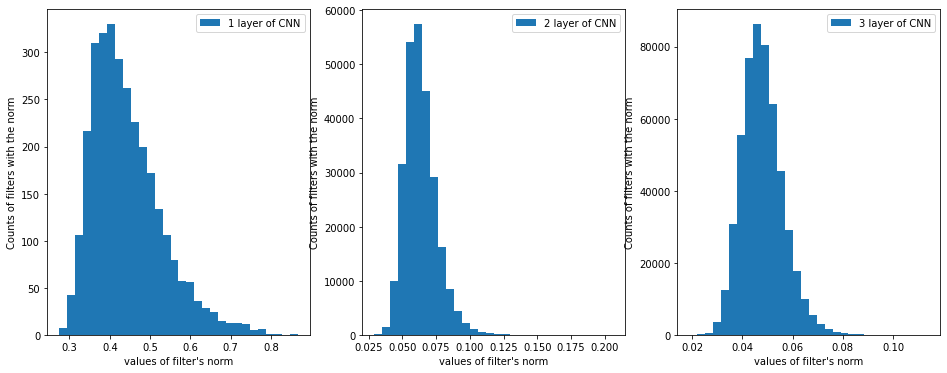

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax = ax.flatten()
for idx in range(3):
  ax[idx].hist(norms[idx], density=False, bins=30,label= str(idx + 1) + " layer of CNN") 
  ax[idx].set_ylabel('Counts of filters with the norm')
  ax[idx].set_xlabel("values of filter's norm")
  ax[idx].legend()
plt.show();

In [10]:
# finally, let me create the dictionary for SKD filters for convenience
SKD_convolutional_weights = {name: filters for name, filters in zip( ['layer_1','layer_2','layer_3'],\
                                                             [filters_1,filters_2,filters_3])}

### 4. Vanilla Discriminator

One can define discriminator as the following MLP network.

In [11]:
class Discriminator(torch.nn.Module):
    def __new__(cls, input_dim, hidden):
        assert isinstance(hidden, list)

        model = [torch.nn.Flatten()]
        hidden_layers = [input_dim] + hidden + [1]
        for in_features, out_features in zip(hidden_layers, hidden_layers[1:]):
            model.extend([
                torch.nn.Linear(in_features, out_features),
                torch.nn.ReLU()
            ])
        model.pop()

        return torch.nn.Sequential(*model)

Let's move on the following part of the experiment that deals with defining loss function of discriminator $\mathbb{D}$.

As we have already said our discriminator returns one logit, because it is inherited from MLP class. However, there should be probability of logit in loss of discriminator like as follow:

The loss of a discriminator
$$
\mathcal{L}_{\mathrm{dis}}(\theta)
    = - \tfrac12 \mathbb{E}_{\mathcal{L}_{\mathrm{teacher}}}
        \log \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{teacher}}))
    - \tfrac12 \mathbb{E}_{ \mathcal{L}_{\mathrm{student}}}
        \log (1 - \sigma(\mathbb{D}_{\theta}(\mathcal{L}_{\mathrm{student}})))
\,. $$

However, this expression is not stable for high($\to$ $\infty$) and low ($\to$ -$\infty$) values for the reason exponent in denominator of sigmoid.

The sigmoid function is:
$$
\sigma(p)
    = \frac1{1 + e^{-p}}
    \,, \sigma(-p) = 1-\sigma(p)$$



However, we have
$$
\ell(y, p)
    = - y \log \sigma(p) - (1-y) \log (1 - \sigma(p))
    %% p > 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^{-p}) + p - y p
    %% p < 0
    % = y \log (1+e^{-p}) + (1-y) \log (1+e^p)
    % = \log (1+e^p) - y p
    = \log (1+e^{-\lvert p\rvert}) - y p + \max \( p, 0 \)
\ $$
which is implemented in `torch.nn.BCEWithLogitsLoss` 



Then, one can define loss for discriminator as follow:

In [12]:
def dis_loss(discriminator,  real, fake, ell=torch.nn.BCEWithLogitsLoss()):
    out_real = discriminator(real)
    out_fake = discriminator(fake.detach())

    loss_real = ell(out_real, torch.full_like(out_real, 0.9))
    loss_fake = ell(out_fake, torch.full_like(out_fake, 0.))
    return loss_real * 0.5 + loss_fake * 0.5

The loss for generator is as follow

In [13]:
def gen_loss_dis(discriminator, *, fake):
    return -discriminator(fake).mean()

The following loss is CrossEntropyLoss and the loss shows how  predicted labels are different from ground-truth labels

In [14]:
def gen_loss_task(model, *, input, target, criterion=torch.nn.CrossEntropyLoss()):
    return criterion(model(input), target)

#### 4.1 Checking of Discriminator

In [15]:
# auxiliary function for calculation
# If loss will be nan or inf
# then there will be exception 
def protect(scalar):
    """Raise if a scalar is either NaN, or Inf."""
    if not isfinite(float(scalar)):
        raise FloatingPointError

    return scalar

Also, one can check the following fact. Is our discriminator sufficiently strong (powerful) in each layer to distinguish  current convolutional filters of CNN  from SKD filters of the same layer.

In [32]:
# this function calculate loss of discrimiantor 
# and backpropogate gradients through all layers of Discriminator
def make_step(diss_loss_fn, discriminator, discriminator_optimizer, real, fake):
  """
  dis_loss_fn : the loss of discriminator, namely "dis_loss" (see above)
  real : batch of SKD filters in a layer
  fake : batch of current convolutional filters in the same layer
  """
  discriminator_optimizer.zero_grad()
  discriminator_loss = diss_loss_fn(discriminator, real, fake)
  protect(discriminator_loss).backward()
  discriminator_optimizer.step()
  return discriminator_loss

In [38]:
def train_epoch_discriminator(discriminator,
                              loader_skd,
                              diss_loss_fn,
                              discriminator_optimizer,
                              ker_iter_gen,
                              current_steps,
                              critic_steps):
  
  """
  loader_skd :  DataLoader for SKD filters
  ker_iter_gen: generator of a batch of convolutional filters
  critic_steps : amount of established critic's steps  
  current_steps : amount of current critic's steps
  """
  

  
  discriminator.requires_grad_(True)
  probs_true, probs_fake, discrim_loss = list(),list(),list()
  # probs_true : probability of discrimiantor on a SKD filter
  # probs_fake : probability of discriminator on a convo filters

  for batch_skd in loader_skd:
    current_steps += 1
    batch_fake = next(ker_iter_gen).detach()

    # to align sizes of batch , when SKD_BATCH_SIZE != BATCH_FAKE_SIZE
    if batch_fake.shape[0] > batch_skd.shape[0]:
      batch_fake = batch_fake[:batch_skd.shape[0]]
    elif batch_fake.shape[0] < batch_skd.shape[0]:
      batch_skd = batch_skd[:batch_fake.shape[0]]

    # make step for a batch
    dis_loss = make_step(diss_loss_fn, discriminator, discriminator_optimizer, batch_skd, batch_fake )

    # calculate probabilities
    probs_true.append(discriminator(batch_skd).detach().sigmoid().mean().cpu().numpy())
    probs_fake.append(discriminator(batch_fake).detach().sigmoid().mean().cpu().numpy())
    discrim_loss.append(dis_loss.detach().cpu().numpy())
 
    # to check , that current_step is still less, than established critic_steps 
    if current_steps == critic_steps:
      break

  return {"discriminator_loss": discrim_loss,
          "probabilities_SKD" : probs_true,
          "probabilities_fitness": probs_fake},current_steps

In [43]:
def train_discriminator(num_epochs,
                        critic_steps,
                        discriminator,
                        loader_skd,
                        diss_loss_fn,
                        discriminator_optimizer,
                        ker_iter_gen):
  
  
  """
  num_epochs : num epochs of a discriminator
  diss_loss_fn :  the loss of discriminator, namely "dis_loss" (see above)
  loader_skd :  DataLoader for SKD filters
  ker_iter_gen: generator of a batch of convolutional filters
  critic_steps : amount of established critic's steps  
  current_steps : amount of current critic's steps
  """

  result_dict = { "discriminator_loss": [],"probabilities_SKD":[],"probabilities_fitness":[] }
  current_steps = 0
  for epoch in tqdm_notebook(range(num_epochs)):
    loss_prob_dict,current_steps = train_epoch_discriminator(discriminator,loader_skd,diss_loss_fn,
                                               discriminator_optimizer,ker_iter_gen,current_steps,critic_steps)
     
    
    for name in result_dict.keys():
      result_dict[name].extend(loss_prob_dict[name])

    # to check , that current_step is still less, than established critic_steps 
    if current_steps >= critic_steps:
      break

  return result_dict

In [52]:
# for the training of discriminator one has to define a model of our CNN
model = SimpleConvNet(n_classes=10).cuda()

Correcting hyperparameters of the following cells one can create the most powerful discriminator

In [53]:
#### hyperparameters ####
# Define batch_size of convolutional filters for each layer
BATCH_CONVO_1 = 256
BATCH_CONVO_2 = 1024
BATCH_CONVO_3 = 1024
#### hyperparameters ####

# Dictionary of batch_sizes of convolutional filters
batch_convo_filters = {"layer_1" :BATCH_CONVO_1, "layer_2" : BATCH_CONVO_2, "layer_3" : BATCH_CONVO_3}
# Dictionary ['layer_1','layer_2','layer_3'] of class' objects 
live_sampler_gen = {name: LiveConv2dSliceInfiniteSampler(module, batch_size = batch_convo_filters[name] ) 
                    for name, module in model.named_modules() if isinstance(module,torch.nn.Conv2d)}
# Dictionary ['layer_1','layer_2','layer_3'] of generators of each layer              
ker_iters_gen = {layer_name: iter(smplr) for layer_name, smplr in live_sampler_gen.items()}

## => batch_convo_filters , live_sampler_gen, ker_iters_gen

In [54]:
#### hyperparameters ####
# Define batch_size of SKD filters
# we are inclined to believe that BATCH_SKD = BATCH_CONVO
BATCH_SKD_1 = 256
BATCH_SKD_2 = 1024
BATCH_SKD_3 = 1024
#### hyperparameters ####

batch_size_SKD = {"layer_1":BATCH_SKD_1, "layer_2" : BATCH_SKD_2, "layer_3" : BATCH_SKD_3}
train_loaders_SKD = {name: torch.utils.data.DataLoader(dataset=SKD_convolutional_weights[name].cuda(),batch_size=batch_size,shuffle=True)\
                        for name, batch_size in batch_size_SKD.items()}
## => train_loaders_SKD

In [55]:
#### hyperparameters ####
# define intermediate layers of Discriminator
HIDDEN_DISCR = [100, 100]
# define learning rate for discriminator of each layer
LR_1 = 1e-3
LR_2 = 1e-3
LR_3 = 1e-3

# define critic steps and diss_loss_fn
DIS_LOSS_FN = dis_loss
CRITIC_STEPS = 2000
NUM_EPOCHS = 1000 
# NUM_EPOCHS should be more than critic_steps//len(train_loaders_SKD[name_of_layer])

#### hyperparameters ####

# create dictionary for learning rates that are connected 
LR_dict = {name: lr for name,lr in zip(["layer_1","layer_2","layer_3"] ,[LR_1,LR_2,LR_3])}

# Dictionary of discriminators
discriminators = torch.nn.ModuleDict({
    name: Discriminator(module.weight.shape[-2:].numel(), HIDDEN_DISCR)
    for name, module in model.named_modules()
    if isinstance(module, torch.nn.Conv2d)
}).cuda()

# dictionary for discriminatpr optimizers
discriminators_optimizers = {name: torch.optim.Adam(model.parameters(),lr=LR_dict[name])
                  for name, model in discriminators.items()}


discrim_check_dict = {name: train_discriminator(NUM_EPOCHS, CRITIC_STEPS, discriminators[name], train_loaders_SKD[name], DIS_LOSS_FN,
                                                discriminators_optimizers[name], ker_iter_gen) 
                      for  name, ker_iter_gen in ker_iters_gen.items()}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Thus, one can see that the discriminator of the first layer requires 165 epohs for 2000 steps , discriminator of the second layer requires 7 epochs and the third discriminator requires 3 epochs.

In [50]:
def plot_loss_probs(discrim_check_dict):
  fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(18,10))
  for name,idx in zip(discrim_check_dict.keys(),[1,3,5]):
    plt.subplot(3,2,idx)
    plt.title(str((idx+2.5)//2.5) + " layer")
    plt.plot(discrim_check_dict[name]['discriminator_loss'],color='olive',label='loss of '+ str((idx+2.5)//2.5) + " discriminator")
    plt.legend()

    plt.subplot(3,2,idx+1)
    plt.title(str((idx+2.5)//2.5) + " layer")
    plt.plot(discrim_check_dict[name]['probabilities_SKD'],color='maroon',label='probabilities of SKD')
    plt.plot(discrim_check_dict[name]['probabilities_fitness'],color='yellowgreen',label='probabilities of fitness')
    plt.legend()
  plt.show()


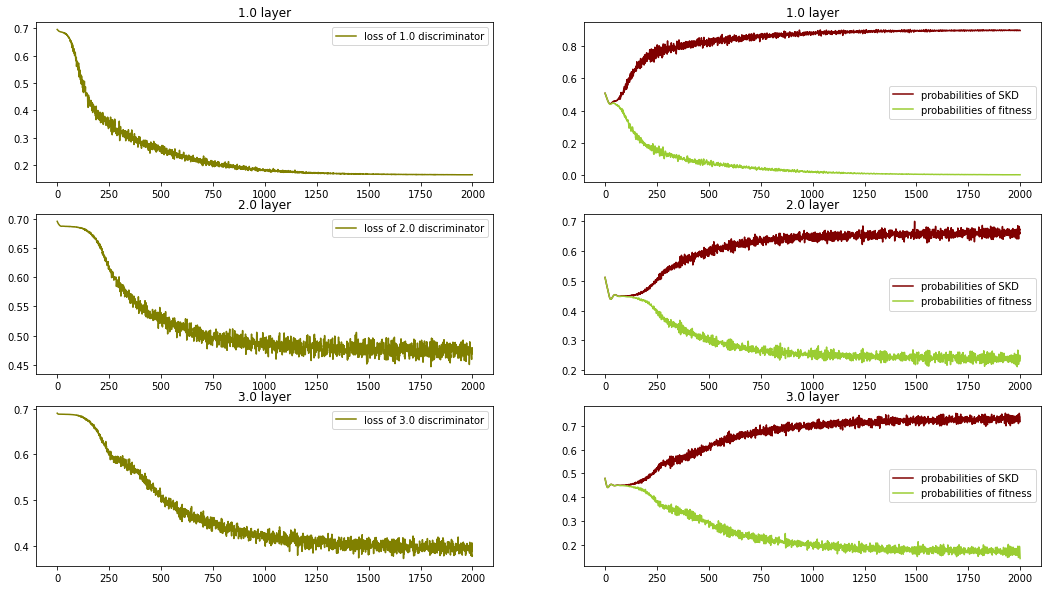

In [56]:
plot_loss_probs(discrim_check_dict)

### 5. Actual Training for CNN with pseudo-generator loss

Beforehand repeat previous some steps, that was described in the section 4.1

In [146]:
# for the  following training  one has to define a model of our CNN again
model = SimpleConvNet(n_classes=10).cuda()

In [147]:
#### hyperparameters ####
# Define batch_size of convolutional filters for each layer
BATCH_CONVO_1 = 256
BATCH_CONVO_2 = 1024
BATCH_CONVO_3 = 1024
#### hyperparameters ####

# Dictionary of batch_sizes of convolutional filters
batch_convo_filters = {"layer_1" :BATCH_CONVO_1, "layer_2" : BATCH_CONVO_2, "layer_3" : BATCH_CONVO_3}
# Dictionary ['layer_1','layer_2','layer_3'] of class' objects 
live_sampler_gen = {name: LiveConv2dSliceInfiniteSampler(module, batch_size = batch_convo_filters[name] ) 
                    for name, module in model.named_modules() if isinstance(module,torch.nn.Conv2d)}
# Dictionary ['layer_1','layer_2','layer_3'] of generators of each layer              
ker_iters_gen = {layer_name: iter(smplr) for layer_name, smplr in live_sampler_gen.items()}

## => batch_convo_filters , live_sampler_gen, ker_iters_gen

In [148]:
#### hyperparameters ####
# Define batch_size of SKD filters
# we are inclined to believe that BATCH_SKD = BATCH_CONVO
BATCH_SKD_1 = 256
BATCH_SKD_2 = 1024
BATCH_SKD_3 = 1024
#### hyperparameters ####

batch_size_SKD = {"layer_1":BATCH_SKD_1, "layer_2" : BATCH_SKD_2, "layer_3" : BATCH_SKD_3}
train_loaders_SKD = {name: torch.utils.data.DataLoader(dataset=SKD_convolutional_weights[name].cuda(),batch_size=batch_size,shuffle=True)\
                        for name, batch_size in batch_size_SKD.items()}
## => train_loaders_SKD

In [149]:
# define intermediate layers of Discriminator
HIDDEN_DISCR = [100, 100]

#crete the dictionary of discriminators
discriminators = torch.nn.ModuleDict({
    name: Discriminator(module.weight.shape[-2:].numel(), HIDDEN_DISCR)
    for name, module in model.named_modules()
    if isinstance(module, torch.nn.Conv2d)
}).cuda()

Now, one can upload the dataset of CIFAR 10. It is worth noticing, that one can set up an amount of elements in the training procedure as follow, thank's to the variable "TRAIN_AMOUNT"

In [151]:
#### hyperparameters ####
# amount data for training
TRAIN_AMOUNT = 500

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, \
                                                 transform=torchvision.transforms.ToTensor(), download=True)
train_dataset, ignore, val_dataset = torch.utils.data.random_split(train_val_dataset, \
                                                                    [TRAIN_AMOUNT, 40000 - TRAIN_AMOUNT , 10000])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [152]:
#### hyperparameters ####
"""
LR_model : learning rate for model
WEIGHT_DECAY : penalization for weights of model
LR_discriminator : learning rate for discriminator
"""
LR_model = 1e-3
WEIGHT_DECAY = 1e-4
LR_discriminator = 1e-3
#### hyperparameters ####

optimizer_generator = torch.optim.Adam(
    model.parameters(), lr=LR_model, weight_decay= WEIGHT_DECAY)

optimizer_discriminator = torch.optim.Adam(
    discriminators.parameters(), lr=LR_discriminator)

In [153]:
#### hyperparameter ####
# batch size for images of cifar10
BATCH_SIZE = 64
#### hyperparameter ####

task_loaders = {
    'train': torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': torch.utils.data.DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'test': torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False),
}

In [154]:
# weights of loss of psudo-generator
BETA_1 = 1e-3
BETA_2 = 1e-3
BETA_3 = 1e-3
# disctionaty of such weights
beta_dictionary = {'layer_1': BETA_1,'layer_2': BETA_2,'layer_3': BETA_3}

In [155]:
# batch_sizes is a dictionary of batches
batch_sizes = {
    'layer_1': 256, 
    'layer_2': 1024,   
    'layer_3': 1024,   
}

In [156]:
#### hyperparameters of convolutional neural network ####
NUM_EPOCHS = 100 # num epochs for convolutional neural network
GENERATOR_STEPS = 100 # steps of generator
DISCRIMINATOR_STEPS = 100 # the number of batches per epoch for each discriminator. 
MAX_GEN_EPOCHS = 1     # num epochs of training of the pseudo-generator
MAX_GEN_DRAWS = 1      # (just use bigger batches) number of model's kernel draws to compute the confuion terms with

#### 5.1 Base code

In [157]:
def plot_learning_curves(history):

  fig = plt.figure(figsize=(50, 20))

  plt.subplot(1,2,1)
  plt.plot(history['loss']['train'],color = 'indigo',label = 'full loss train')
  plt.plot(history['task_loss']['train'], color = 'tomato',label = 'task loss')
  plt.plot(history['pseudo_gen_loss']['train'] ,color= 'gold',label = 'pseudo gen loss')
  plt.plot(history['loss']['val'],color = 'limegreen',label = 'validation loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history['acc']['train'],color= 'midnightblue',label= 'train accuracy')
  plt.plot(history['acc']['val'],color = 'firebrick' ,label = 'validation accuracy')
  plt.legend()
  
  fig,ax = plt.subplots(3,1,figsize=(20,20))
  ax = ax.flatten()
  for idx,layers_,bt in zip(range(3),['layer_1','layer_2','layer_3'],[256,1024,1024]):
    ax[idx].plot(history['prob_true'][layers_],color='purple',label='SKD filters ' + str(idx + 1) + ' layer')
    ax[idx].plot(history['prob_fake'][layers_],color='salmon',label='fitness filters' + str(idx + 1) + ' layer')
    ax[idx].axhline(0.5, color='blue')
    ax[idx].set_ylim([0,1])
    ax[idx].set_ylabel('probability')
    ax[idx].set_xlabel('num iterations')
    ax[idx].set_title('500 samples per train : Batch '  + str(bt))
    ax[idx].legend()

  plt.show()

In [158]:
def train_CNN(num_epochs,
              max_gen_epochs,
              generator_steps,
              max_gen_draws,
              model,
              discriminators,
              task_loaders,
              beta_dictionary,
              optimizer_generator,
              optimizer_discriminator,
              discriminator_steps,
              ker_iters_gen):

  """
  num_epochs : num_epochs of CNN
  max_gen_epochs : amount epochs of generator (by default 1)
  generator_steps: amount steps of pseudo-generator
  max_gen_draws : 
  model : CNN
  discriminators : dictionary of discriminators
  task_loaders : dictionary of train loaders of CIFAR10 for CNN
  beta_dictionary : dictionary of constants of pseudo-generator loss
  optimizer_generator: optimizer of CNN
  optimizer_discriminator : optimizer of a discriminator
  discriminator_steps : amount steps of discriminator
  ker_iters_gen: generator for a batch of current convolutional filters in a layer

  """
  
  history = defaultdict(lambda: defaultdict(list))

  

  betas_history = {layer: [value] for layer, value in beta_dictionary.items()}
  

  accuracy_train = []
  accuracy_val = []

  for epoch in tqdm_notebook(range(num_epochs)):

    train_loss   =    0
    train_acc    =    0

    val_loss =        0
    val_acc  =        0 

    start_time = time.time()
    
    # training of model
    model.requires_grad_(True)
    # all discriminators eval
    for discriminator in discriminators.values():
      discriminator.requires_grad_(False)

 
    for generator_epoch in tqdm.tqdm(range(max_gen_epochs)):
      for num_batch,(batch_x,batch_y) in zip(range(generator_steps), task_loaders['train']):
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        # calculate CrossEntropyLoss
        loss_task = gen_loss_task(model, input=batch_x, target = batch_y.long())

        # calculate pseudo-generator loss throughout all layers
        dis_terms = {
                (layer): gen_loss_dis(dis, fake=next(ker_iters_gen[layer]).view(-1,\
                                                                                   next(ker_iters_gen[layer]).shape[-1]*\
                                         next(ker_iters_gen[layer]).shape[-2] ))
                 for layer, dis in discriminators.items()
 
                 }

        # calculate sum loss : CrossEntropyLoss + pseudo-generator loss of each layer
        value = loss_task + sum(
        beta_dictionary.get(layer) * term
        for layer, term in dis_terms.items())
        
        # to get accuracy let's calculate predictions of the CNN
        logits_train = model(batch_x)
        y_pred_train = logits_train.max(1)[1].detach().cpu().numpy()
        train_acc += np.mean(batch_y.cpu().numpy() == y_pred_train)

        train_loss += np.sum(value.detach().cpu().numpy())
         
        # backpropogation
        optimizer_generator.zero_grad() 
        protect(value).backward()
        optimizer_generator.step()
        
         
    # normalizing train_loss and train_acc  
    train_loss /= len(task_loaders['train'])
    train_acc /= len(task_loaders['train'])

    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)

    accuracy_train.append(train_acc)
 
    
    # training of discriminator
    # model's gradient doesn't backprop
    
    model.requires_grad_(False)
    for discriminator in discriminators.values():
      discriminator.requires_grad_(True)

    for _ in tqdm.tqdm(range(discriminator_steps)):
      loss = {}
      for layer, dis in discriminators.items(): 
        
        # get a batch of SKD filters and a batch of current convo filters
        real = next(iter(train_loaders_SKD[layer])).cuda()
        fake = next(ker_iters_gen[layer]).detach()
        
        # to align batch sizes when BATCH_SIZE_SKD != BATCH_SIZE_CONVO
        if real.shape[0] < fake.shape[0]:
          fake = fake[:real.shape[0]]
        elif real.shape[0] > fake.shape[0]:
          real = real[:fake.shape[0]]

        # calculate loss of dsicriminator in a batch
        loss[layer] = dis_loss(dis, real=real, fake=fake)

        # 
        history['prob_true'][layer].append(dis(real).detach().sigmoid().mean().cpu().numpy())
        history['prob_fake'][layer].append(dis(fake).detach().sigmoid().mean().cpu().numpy())
        
      value = sum(loss.values())

      #backprop for a discriminator of a layer
      optimizer_discriminator.zero_grad()
      protect(value).backward()
      optimizer_discriminator.step()

    
    with torch.no_grad():
      # eval model 
      model.requires_grad_(False)

      for batch_x,batch_y in tqdm.tqdm(task_loaders['val']):
        batch_x,batch_y = batch_x.cuda(), batch_y.cuda()

        # calculate CrossEntropyLoss
        loss_ = gen_loss_task(model,input=batch_x,target = batch_y)
        
        # calculate predictions in a validation
        val_loss += np.sum(loss_.detach().cpu().numpy())
        logits_ = model(batch_x)
        y_pred_ = logits_.max(1)[1].detach().cpu().numpy()
        val_acc += np.mean(batch_y.cpu().numpy() == y_pred_)

      #  normalizing of loss and accuracy
      val_loss /= len(task_loaders['val'])
      val_acc /= len(task_loaders['val']) 

      history['loss']['val'].append(val_loss)
      history['acc']['val'].append(val_acc)

    
    ## feedback for the generator's objective hyperparameters
    out = {}  # inflate, keep, or deflate the weight in the generator's objective
    for layer, value in beta_dictionary.items():
      p_real, p_fake = history['prob_true'][layer][-1], history['prob_fake'][layer][-1]
      if p_fake < 0.2:
        value = value * 2.

      elif p_fake > 0.45:
        value = value / 2.

      out[layer] = max(1e-3, min(1e3, value))

      betas_history[layer].append(out[layer])

    beta_dictionary = out 

    clear_output()
        
    #print results after each epoch
    print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
    print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
    print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
    plot_learning_curves(history)
  return model, history

Epoch 100 of 100 took 9.749s
  training loss (in-iteration): 	0.208076
  validation loss (in-iteration): 	3.845267
  training accuracy: 			100.00 %
  validation accuracy: 			37.80 %


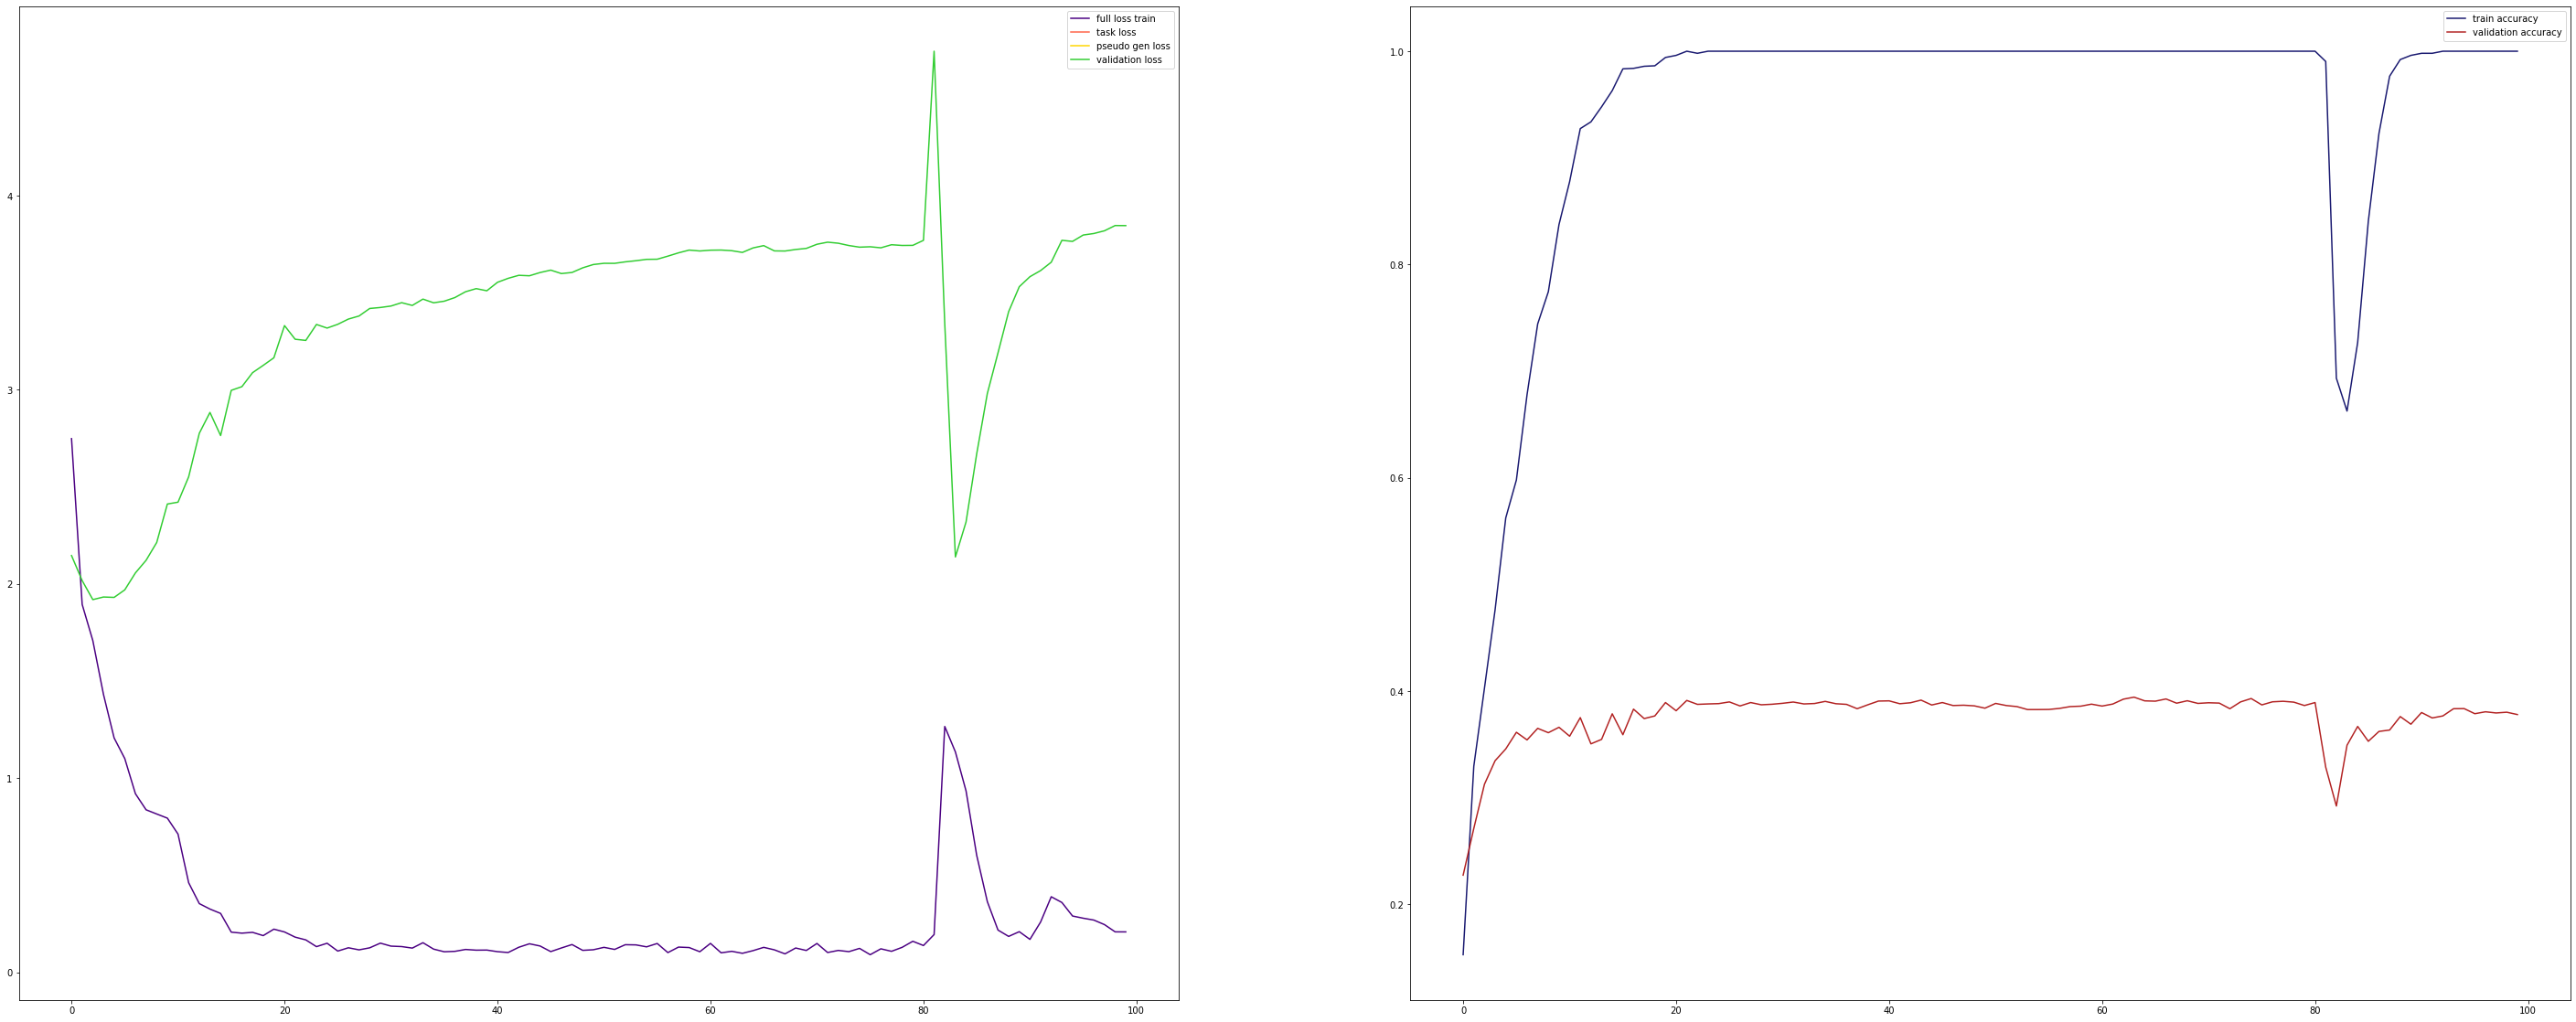

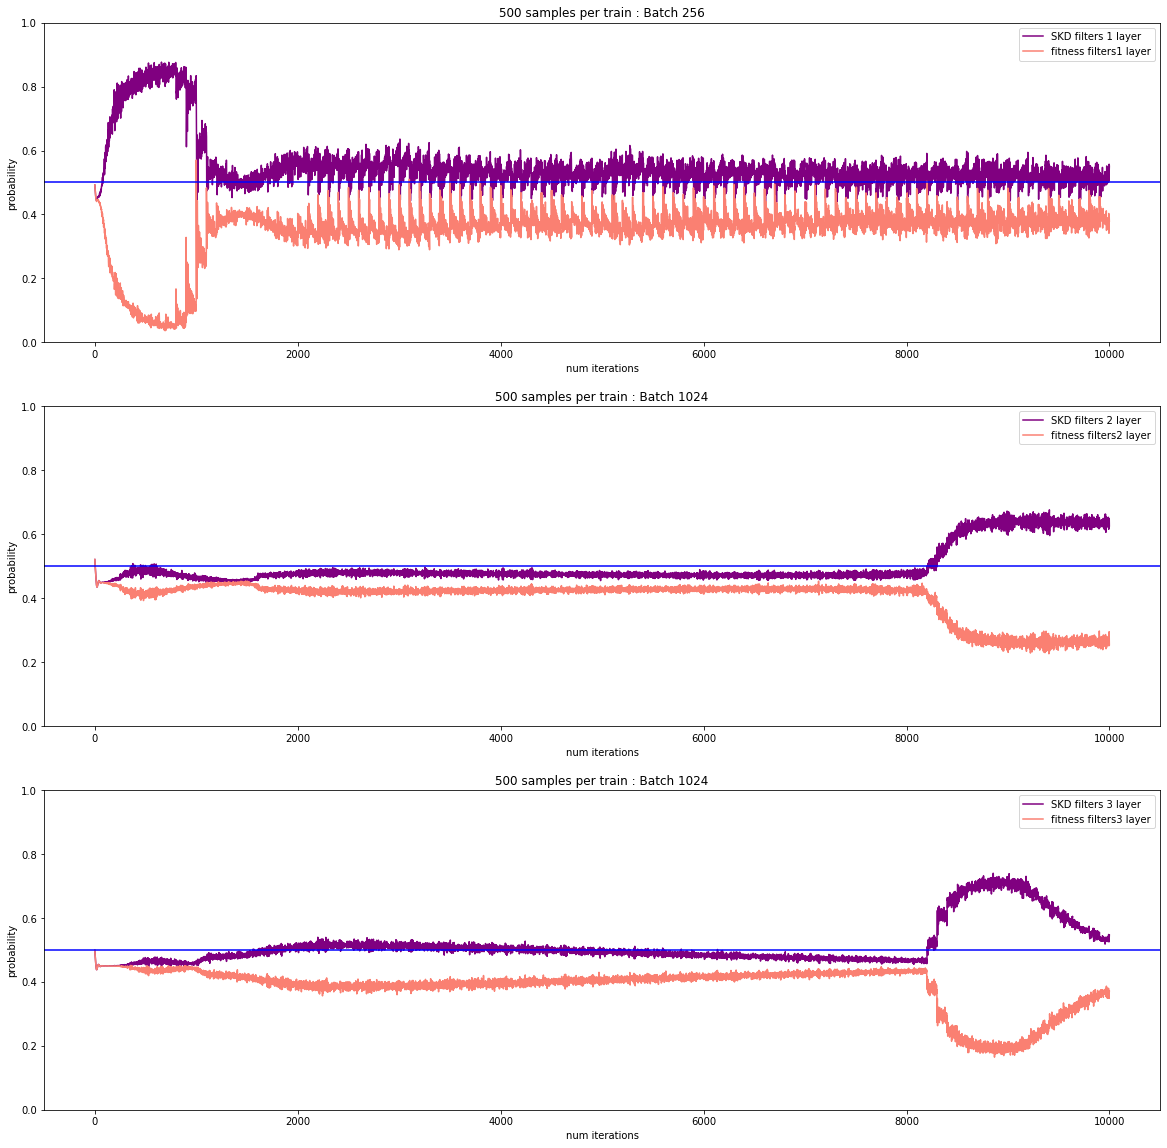

In [159]:
model,history = train_CNN(NUM_EPOCHS,
                          MAX_GEN_EPOCHS,
              GENERATOR_STEPS,
              MAX_GEN_DRAWS,
              model,
              discriminators,
              task_loaders,
              beta_dictionary,
              optimizer_generator,
              optimizer_discriminator,
              DISCRIMINATOR_STEPS,
              ker_iters_gen)

In [166]:
model_ = SimpleConvNet(n_classes=10).cuda()
optimizer_model = torch.optim.Adam(model_.parameters(),lr = 1e-3)

In [167]:
def accuracy_without_adversarial(num_epochs, model_steps, model, optimizer_model):
  acc_train = []
  acc_val = []

  for epoch in tqdm_notebook(range(num_epochs)):
    train_acc = 0
    val_acc = 0
    model.requires_grad_(True)

    for num_batch, (batch_x, batch_y) in zip(range(model_steps), task_loaders['train']):
      batch_x, batch_y = batch_x.cuda(),batch_y.cuda()
      
      # batch-averaged cross entroppy loss
      value = gen_loss_task(model, input=batch_x, target=batch_y)

      logits = model(batch_x)
      y_pred = logits.max(1)[1].detach().cpu().numpy()
      train_acc += np.mean(by.cpu().numpy() == y_pred)

      optimizer_model.zero_grad()
      protect(value).backward()
      optimizer_model.step()   
  
    acc_train.append(train_acc)
 
    with torch.no_grad():

      model.eval()
      for batch_x, batch_y in task_loaders['val']:
        batch_x,batch_y = batch_x.cuda(),batch_y.cuda()
        loss_ = gen_loss_task(model, input=batch_x, target=batch_y)
        logits_ = model(batch_x)
        y_pred_ = logits_.max(1)[1].detach().cpu().numpy()
        val_acc += np.mean(batch_y.cpu().numpy() == y_pred_)
    
    val_acc /= len(task_loaders['val'])
    acc_val.append(val_acc)
  return acc_val

In [168]:
acc_ = accuracy_without_adversarial(NUM_EPOCHS, GENERATOR_STEPS, model_, optimizer_model )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### 6. Desired plot

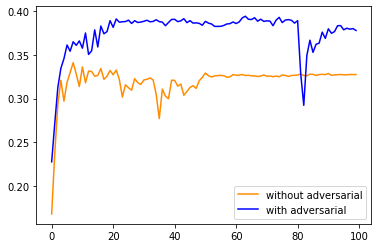

In [170]:
plt.plot(acc_,color='darkorange',label='without adversarial')
plt.plot(history['acc']['val'],color = 'blue',label='with adversarial')
plt.legend()
plt.show()